In [1]:
from data_cube_analysis import getdata, rms, masks, moments
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import spectral_cube
import numpy as np
import warnings
import scipy
warnings.filterwarnings('ignore')

In [2]:
inputfile = '/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_lowres/HNCO_7m12mTP_CubeMosaic_downsample9.fits'
# inputfile = '/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_lowres/HNCO_7m12mTP_CubeMosaic_downsample9_downsamplespectrally.fits'

In [3]:
# cube = getdata.get_cube(inputfile)
# cube.allow_huge_operations=True
# spectral_axis = cube.spectral_axis[::10]
# cube_specsampled = cube.spectral_interpolate(spectral_axis)
# cube_specsampled.write(inputfile.replace('.fits', '_downsamplespectrally.fits'), overwrite=True)

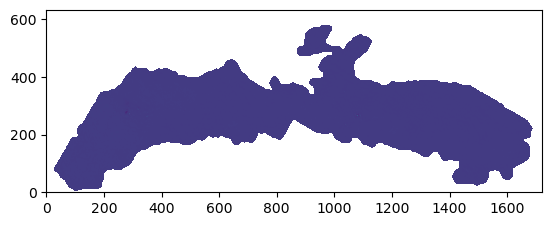

In [8]:
# Do contsub 
hdu = fits.open(inputfile)[0]
hdu.header['BUNIT'] = 'Jy/Beam'
cube = getdata.get_cube(hdu)
rms_map1 = rms.get_rmsrob(cube)
# rms_map2 = rms.get_rms(cube, [[-140, -90],[90, 140]])
rms_map1.data = np.float32(rms_map1.data)
# rms_map2.data = np.float32(rms_map2.data)
# rms_map1.data[np.isnan(rms_map1.data)] = rms_map2.data[np.isnan(rms_map1.data)]

mask = masks.get_expmask(cube, rms_map1, hthresh=5, lthresh=3, npix=10)
cube_masked = cube.with_mask(mask)

cube_revmasked = cube.with_mask(~mask)
cont = np.nanmean(cube_revmasked, axis=0)
cont[cont == 0] = np.nan
fits.PrimaryHDU(cont, rms_map1.header).writeto(inputfile.replace('.fits', '.cont.fits'), overwrite=True)
plt.imshow(cont, origin='lower')

hdu_contsub = cube.hdu 
hdu_contsub.data = hdu_contsub.data - cont
hdu_contsub.data = np.float32(hdu_contsub.data)
hdu_contsub.writeto(inputfile.replace('.fits', '.contsub.fits'), overwrite=True)

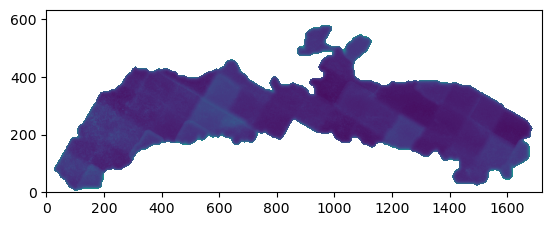

In [9]:
# Mask cube
cube = spectral_cube.SpectralCube.read(inputfile.replace('.fits', '.contsub.fits'))
rms_map1 = rms.get_rmsrob(cube)
rms_map2 = rms.get_rms(cube, [[-140, -90],[90, 140]])
rms_map1.data = np.float32(rms_map1.data)
rms_map2.data = np.float32(rms_map2.data)
rms_map1.data[np.isnan(rms_map1.data)] = rms_map2.data[np.isnan(rms_map1.data)]

rms_map1.writeto(inputfile.replace('.fits', '.rms.fits'), overwrite=True)
# rms_map2.writeto(inputfile.replace('.fits', '.rms2.fits'), overwrite=True)

plt.imshow(np.sqrt(rms_map1.data), origin='lower')

mask = masks.get_expmask(cube, rms_map1, hthresh=3, lthresh=1, npix=5)
cube_masked = cube.with_mask(mask)

hdu_masked = cube_masked.hdu
hdu_masked.data = np.float32(hdu_masked.data)
hdu_masked.writeto(inputfile.replace('.fits', '.masked.fits'), overwrite=True)

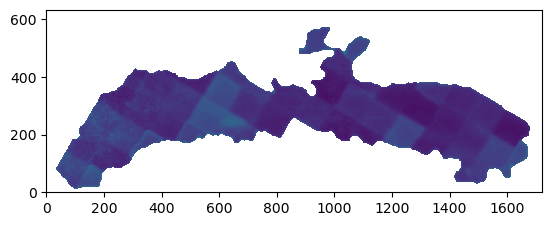

In [16]:
cube = spectral_cube.SpectralCube.read(inputfile.replace('.fits', '.contsub.fits'))
data = cube.hdu.data
header = cube.hdu.header

mask = np.isnan(data)
mask = scipy.ndimage.binary_dilation(mask, iterations=7)
data[mask] = np.nan
cube = spectral_cube.SpectralCube.read(fits.PrimaryHDU(data, header))

cube.allow_huge_operations=True
mom_max = cube.max(axis=(0))
mom_max.write(inputfile.replace('.fits', '.contsub.max.fits'), overwrite=True)

# Mask cube
rms_map1 = rms.get_rmsrob(cube)
rms_map2 = rms.get_rms(cube, [[-140, -90],[90, 140]])
rms_map1.data = np.float32(rms_map1.data)
rms_map2.data = np.float32(rms_map2.data)
rms_map1.data[np.isnan(rms_map1.data)] = rms_map2.data[np.isnan(rms_map1.data)]

rms_map1.writeto(inputfile.replace('.fits', '.masked.rms.fits'), overwrite=True)

plt.imshow(np.sqrt(rms_map1.data), origin='lower')

mask = masks.get_expmask(cube, rms_map1, hthresh=3, lthresh=1, npix=5)
cube_masked = cube.with_mask(mask)

cube_masked.allow_huge_operations=True
mom_max = cube_masked.max(axis=(0))
mom_max.write(inputfile.replace('.fits', '.contsub.masked.max.fits'), overwrite=True)
